In [1]:
import pathlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor
import cv2

from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor

from sklearn.metrics import classification_report, confusion_matrix

from captum.attr import IntegratedGradients
from captum.attr import Saliency
from captum.attr import DeepLift
from pytorch_grad_cam import GradCAM

/home/davide/Desktop/SAM_tests/SAM_tests/env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [3]:
# create a dataset and dataloader for the data
data_dir_train = pathlib.Path('../../data/skincancer_new_processed_binary/train_binary/images')
data_dir_test = pathlib.Path('../../data/skincancer_new_processed_binary/test_binary/images')

In [4]:
ground_truth_file_test = pathlib.Path('../../data/skincancer_new_processed_binary/test_GroundTruth2_binary.csv')
ground_truth_file_train = pathlib.Path('../../data/skincancer_new_processed_binary/train_GroundTruth2_binary.csv')

In [5]:
mask_dir_train = pathlib.Path('../../data/skincancer_new_processed_binary/train_binary/masks')
mask_dir_test = pathlib.Path('../../data/skincancer_new_processed_binary/test_binary/masks')

In [6]:
train_ids = [f.stem for f in data_dir_train.glob("*.png")]
test_ids = [f.stem for f in data_dir_test.glob("*.png")]

In [7]:
#train_ids

In [8]:
class Dataset_skincancer_custom(Dataset):
    def __init__(self, image_dir, ground_truth_file, ids, mask_dir, transform=None):
        """
        Args:
            image_dir (pathlib.Path): Directory with all the images.
            ground truth: num
            transform (callable, optional): Optional additional transform to be applied on an image/mask.
        """
        self.image_dir = image_dir
        self.ground_truth_file = ground_truth_file
        self.mask_dir = mask_dir
        self.ids = ids
        self.transform = transform
        self.to_tensor = ToTensor()  # Define ToTensor transformation

    def __len__(self):
        return len(self.ids)

    def __getitem__(self, idx):
        name = self.ids[idx]
        # Load image and mask
        image = np.array(Image.open(self.image_dir / f"{name}.png").convert("RGB"))
        image = self.to_tensor(image)
        mask = np.array(Image.open(self.mask_dir / f"{name}_segmentation.png").convert("L"))
        mask = self.to_tensor(mask)
        
        # Load ground truth
        ground_truth_df = pd.read_csv(self.ground_truth_file)
        ground_truth = ground_truth_df[ground_truth_df['image_id'] == name][['melanoma', 'seborrheic_keratosis']].values
        ground_truth = torch.tensor(ground_truth, dtype=torch.float32)
        ground_truth = ground_truth.squeeze()
        #mask = np.array(mask)

        # Apply ToTensor transformation
        #image = self.to_tensor(image)
        #mask = self.to_tensor(mask)


        ## Apply additional transformations if provided
        #if self.transform:
        #    image = self.transform(image)
        #    mask = self.transform(mask)
        
        #print(image)
        #print(ground_truth)

        return image, ground_truth, mask

In [9]:
batch_size = 16

In [10]:
# Create datasets with transformations
dataset_train = Dataset_skincancer_custom(data_dir_train, ground_truth_file_train, train_ids, mask_dir_train)
dataset_test = Dataset_skincancer_custom(data_dir_test, ground_truth_file_test, test_ids, mask_dir_test)

# Create dataloaders
train_loader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True, num_workers=4)
test_loader = DataLoader(dataset_test, batch_size=1, shuffle=False, num_workers=4)

In [11]:
for i, item in enumerate(test_loader):
    print(item)
    if i == 0:
        break

[tensor([[[[0.6000, 0.6000, 0.5922,  ..., 0.6157, 0.6627, 0.6510],
          [0.6000, 0.6000, 0.5882,  ..., 0.6078, 0.6353, 0.6627],
          [0.5961, 0.5961, 0.5882,  ..., 0.6078, 0.6157, 0.6627],
          ...,
          [0.5804, 0.5843, 0.6157,  ..., 0.5843, 0.5804, 0.5882],
          [0.5843, 0.5804, 0.5961,  ..., 0.5725, 0.5843, 0.5922],
          [0.5843, 0.5804, 0.5843,  ..., 0.5765, 0.5882, 0.6000]],

         [[0.5647, 0.5608, 0.5529,  ..., 0.5765, 0.6353, 0.6235],
          [0.5608, 0.5569, 0.5451,  ..., 0.5686, 0.6039, 0.6353],
          [0.5569, 0.5529, 0.5412,  ..., 0.5647, 0.5765, 0.6314],
          ...,
          [0.5294, 0.5412, 0.5922,  ..., 0.5451, 0.5255, 0.5294],
          [0.5333, 0.5333, 0.5647,  ..., 0.5294, 0.5294, 0.5373],
          [0.5333, 0.5255, 0.5451,  ..., 0.5255, 0.5333, 0.5529]],

         [[0.5608, 0.5569, 0.5412,  ..., 0.5804, 0.6471, 0.6314],
          [0.5569, 0.5490, 0.5333,  ..., 0.5647, 0.6039, 0.6392],
          [0.5490, 0.5451, 0.5255,  ..., 

In [12]:
for i, item in enumerate(train_loader):
    print(item)
    if i == 0:
        break

[tensor([[[[0.6118, 0.6275, 0.6235,  ..., 0.7020, 0.7137, 0.7176],
          [0.6118, 0.6314, 0.6196,  ..., 0.7059, 0.6941, 0.7059],
          [0.6078, 0.6235, 0.6353,  ..., 0.7137, 0.6902, 0.7059],
          ...,
          [0.8000, 0.8314, 0.8549,  ..., 0.7569, 0.7569, 0.7608],
          [0.7843, 0.8196, 0.8392,  ..., 0.7529, 0.7569, 0.7686],
          [0.7843, 0.8078, 0.8392,  ..., 0.7569, 0.7569, 0.7725]],

         [[0.4196, 0.4706, 0.4510,  ..., 0.5412, 0.5725, 0.5804],
          [0.4275, 0.4745, 0.4275,  ..., 0.5529, 0.5294, 0.5451],
          [0.4039, 0.4392, 0.4667,  ..., 0.5608, 0.5176, 0.5451],
          ...,
          [0.7529, 0.7922, 0.8275,  ..., 0.6039, 0.6157, 0.6235],
          [0.7333, 0.7725, 0.8039,  ..., 0.6039, 0.6000, 0.6275],
          [0.7294, 0.7569, 0.8000,  ..., 0.6000, 0.6000, 0.6314]],

         [[0.3569, 0.3961, 0.3686,  ..., 0.4000, 0.4549, 0.4824],
          [0.3725, 0.4039, 0.3333,  ..., 0.4275, 0.3882, 0.4235],
          [0.3333, 0.3608, 0.3804,  ..., 

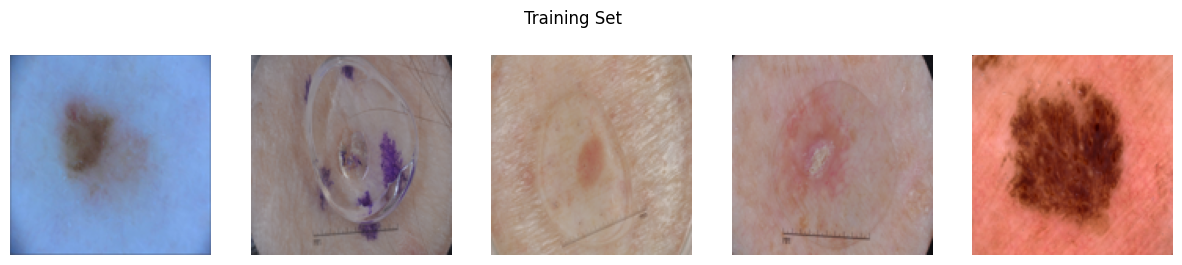

In [13]:
# plot the first 5 images in the training set, the first 5 images in the test set
def plot_images(loader, title):
    fig, axs = plt.subplots(1, 5, figsize=(15, 3))
    for i, (image, _, _) in enumerate(loader):
        if i == 5:
            break
        axs[i].imshow(image[i].permute(1, 2, 0))
        axs[i].axis("off")
    fig.suptitle(title)
    plt.show()

plot_images(train_loader, "Training Set")
#plot_images(test_loader, "Test Set")

In [14]:
#class CustomCNN(torch.nn.Module):
#    def __init__(self):
#        super(CustomCNN, self).__init__()
#        
#        # Convolutional base
#        self.conv1 = torch.nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2)
#        self.bn1 = torch.nn.BatchNorm2d(64)
#        self.relu1 = torch.nn.LeakyReLU()
#        self.pool1 = torch.nn.MaxPool2d(kernel_size=3, stride=2)
#
#        self.conv2 = torch.nn.Conv2d(64, 192, kernel_size=5, padding=2)
#        self.bn2 = torch.nn.BatchNorm2d(192)
#        self.relu2 = torch.nn.LeakyReLU()
#        self.pool2 = torch.nn.MaxPool2d(kernel_size=3, stride=2)
#
#        self.conv3 = torch.nn.Conv2d(192, 384, kernel_size=3, padding=1)
#        self.bn3 = torch.nn.BatchNorm2d(384)
#        self.relu3 = torch.nn.LeakyReLU()
#
#        self.conv4 = torch.nn.Conv2d(384, 256, kernel_size=3, padding=1)
#        self.bn4 = torch.nn.BatchNorm2d(256)
#        self.relu4 = torch.nn.LeakyReLU()
#
#        self.conv5 = torch.nn.Conv2d(256, 256, kernel_size=3, padding=1)
#        self.bn5 = torch.nn.BatchNorm2d(256)
#        self.relu5 = torch.nn.LeakyReLU()
#
#        # ➕ Added sixth conv layer (deeper)
#        self.conv6 = torch.nn.Conv2d(256, 256, kernel_size=3, padding=1)
#        self.bn6 = torch.nn.BatchNorm2d(256)
#        self.relu6 = torch.nn.LeakyReLU()
#
#        # ➕ Added 1x1 convolution (bottleneck idea)
#        self.conv1x1 = torch.nn.Conv2d(256, 128, kernel_size=1)
#        self.bn1x1 = torch.nn.BatchNorm2d(128)
#        self.relu1x1 = torch.nn.LeakyReLU()
#
#        self.pool3 = torch.nn.AdaptiveAvgPool2d((3, 3))
#
#        self.flatten = torch.nn.Flatten()
#        
#        # ➕ Increased FC layer depth
#        self.fc1 = torch.nn.Linear(128 * 3 * 3, 4096)
#        self.relu_fc1 = torch.nn.LeakyReLU()
#        self.dropout1 = torch.nn.Dropout(0.5)
#
#        self.fc2 = torch.nn.Linear(4096, 2048)
#        self.relu_fc2 = torch.nn.LeakyReLU()
#        self.dropout2 = torch.nn.Dropout(0.10)
#
#        self.fc3 = torch.nn.Linear(2048, 1024)
#        self.relu_fc3 = torch.nn.LeakyReLU()
#        self.dropout3 = torch.nn.Dropout(0.05)
#
#        self.fc4 = torch.nn.Linear(1024, 2)  # Final output
#
#    def forward(self, x):
#        x = self.pool1(self.relu1(self.bn1(self.conv1(x))))
#        x = self.pool2(self.relu2(self.bn2(self.conv2(x))))
#        x = self.relu3(self.bn3(self.conv3(x)))
#        x = self.relu4(self.bn4(self.conv4(x)))
#        x = self.relu5(self.bn5(self.conv5(x)))
#        x = self.relu6(self.bn6(self.conv6(x)))
#        x = self.relu1x1(self.bn1x1(self.conv1x1(x)))
#        x = self.pool3(x)
#        x = self.flatten(x)
#        x = self.dropout1(self.relu_fc1(self.fc1(x)))
#        x = self.dropout2(self.relu_fc2(self.fc2(x)))
#        x = self.dropout3(self.relu_fc3(self.fc3(x)))
#        x = self.fc4(x)
#        return x
#    
## create model
#model = CustomCNN().to(device)
#model.to(device)

In [ ]:

class CustomCNN(torch.nn.Module):
    def __init__(self):
        super(CustomCNN, self).__init__()

        # Convolutional base
        self.conv1 = torch.nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2)
        self.bn1 = torch.nn.BatchNorm2d(64)
        self.relu1 = torch.nn.LeakyReLU()
        self.pool1 = torch.nn.MaxPool2d(kernel_size=3, stride=2)

        self.conv2 = torch.nn.Conv2d(64, 192, kernel_size=5, padding=2)
        self.bn2 = torch.nn.BatchNorm2d(192)
        self.relu2 = torch.nn.LeakyReLU()
        self.pool2 = torch.nn.MaxPool2d(kernel_size=3, stride=2)

        self.conv3 = torch.nn.Conv2d(192, 384, kernel_size=3, padding=1)
        self.bn3 = torch.nn.BatchNorm2d(384)
        self.relu3 = torch.nn.LeakyReLU()

        self.conv4 = torch.nn.Conv2d(384, 256, kernel_size=3, padding=1)
        self.bn4 = torch.nn.BatchNorm2d(256)
        self.relu4 = torch.nn.LeakyReLU()

        self.conv5 = torch.nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.bn5 = torch.nn.BatchNorm2d(256)
        self.relu5 = torch.nn.LeakyReLU()

        self.conv6 = torch.nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.bn6 = torch.nn.BatchNorm2d(256)
        self.relu6 = torch.nn.LeakyReLU()

        # ✅ 1x1 Convolution
        self.conv1x1 = torch.nn.Conv2d(256, 128, kernel_size=1)
        self.bn1x1 = torch.nn.BatchNorm2d(128)
        self.relu1x1 = torch.nn.LeakyReLU()

        # Conv7
        self.conv7 = torch.nn.Conv2d(128, 64, kernel_size=3, padding=1)
        self.bn7 = torch.nn.BatchNorm2d(64)
        self.relu7 = torch.nn.LeakyReLU()

        self.pool3 = torch.nn.AdaptiveAvgPool2d((3, 3))
        self.flatten = torch.nn.Flatten()

        # Fully connected layers
        self.fc1 = torch.nn.Linear(64 * 3 * 3, 4096)
        self.relu_fc1 = torch.nn.LeakyReLU()
        self.dropout1 = torch.nn.Dropout(0.0)

        self.fc2 = torch.nn.Linear(4096, 2048)
        self.relu_fc2 = torch.nn.LeakyReLU()
        self.dropout2 = torch.nn.Dropout(0.5)

        self.fc3 = torch.nn.Linear(2048, 1024)
        self.relu_fc3 = torch.nn.LeakyReLU()
        self.dropout3 = torch.nn.Dropout(0.3)

        self.fc4 = torch.nn.Linear(1024, 512)
        self.relu_fc4 = torch.nn.LeakyReLU()
        self.dropout4 = torch.nn.Dropout(0.3)

        self.fc5 = torch.nn.Linear(512, 2)

    def forward(self, x):
        x = self.pool1(self.relu1(self.bn1(self.conv1(x))))
        x = self.pool2(self.relu2(self.bn2(self.conv2(x))))
        x = self.relu3(self.bn3(self.conv3(x)))
        x = self.relu4(self.bn4(self.conv4(x)))
        x = self.relu5(self.bn5(self.conv5(x)))
        x = self.relu6(self.bn6(self.conv6(x)))
        x = self.relu1x1(self.bn1x1(self.conv1x1(x)))
        x = self.relu7(self.bn7(self.conv7(x)))
        x = self.pool3(x)
        x = self.flatten(x)
        x = self.dropout1(self.relu_fc1(self.fc1(x)))
        x = self.dropout2(self.relu_fc2(self.fc2(x)))
        x = self.dropout3(self.relu_fc3(self.fc3(x)))
        x = self.dropout4(self.relu_fc4(self.fc4(x)))
        x = self.fc5(x)
        return x



# create model
model = CustomCNN().to(device)
model.to(device)

CustomCNN(
  (conv1): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): LeakyReLU(negative_slope=0.01)
  (pool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (bn2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): LeakyReLU(negative_slope=0.01)
  (pool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): LeakyReLU(negative_slope=0.01)
  (conv4): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu4): LeakyRe

In [16]:
# test model with a random input
x = torch.randn(1, 3, 128, 128).to(device)
y = model(x)
print(y)

tensor([[-0.0092, -0.0143]], device='cuda:0', grad_fn=<AddmmBackward0>)


In [17]:
## test model with the first batch of the training data
#for i, item in enumerate(train_loader):
#    if i == 1:
#        break
#    print(item[0].shape)  # Print the shape of the images in the batch
#    print(item[1].shape)  # Print the shape of the ground truth labels in the batch
#    print(item[2].shape)  # Print the shape of the masks in the batch
#    print(item[1])

In [18]:
# test model with the first batch of the training data
for i, (image, ground_truth, mask) in enumerate(train_loader):
    if i == 1:
        break
    image = image.to(device)
    ground_truth = ground_truth.to(device)
    output = model(image)
    # convert output to tensor with 1 on the predicted class and 0 on the other classes
    _, predicted_max = torch.max(output, 1)
    print(output)
    output = torch.zeros_like(output)
    output[torch.arange(output.size(0)), predicted_max] = 1
    print(output)
    print(ground_truth)

tensor([[-0.0121, -0.0167],
        [-0.0143, -0.0055],
        [-0.0167, -0.0145],
        [-0.0120, -0.0146],
        [-0.0053, -0.0085],
        [-0.0146, -0.0080],
        [-0.0185, -0.0086],
        [-0.0134, -0.0142],
        [-0.0158, -0.0116],
        [-0.0207, -0.0124],
        [-0.0124, -0.0139],
        [-0.0098, -0.0148],
        [-0.0046, -0.0209],
        [-0.0160, -0.0219],
        [-0.0158, -0.0191],
        [-0.0205, -0.0123]], device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([[1., 0.],
        [0., 1.],
        [0., 1.],
        [1., 0.],
        [1., 0.],
        [0., 1.],
        [0., 1.],
        [1., 0.],
        [0., 1.],
        [0., 1.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [0., 1.]], device='cuda:0')
tensor([[0., 1.],
        [1., 0.],
        [0., 1.],
        [1., 0.],
        [0., 1.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
    

In [19]:
# create a custom tensor of size 1x8x3
tensor_weights = torch.ones(16, 2).to(device)
# multiply first column by 0.5
tensor_weights[:, 0] = tensor_weights[:, 0] * (628/374)
# multiply second column by 0.25
tensor_weights[:, 1] = tensor_weights[:, 1] * (628/256)
print(tensor_weights)

tensor([[1.6791, 2.4531],
        [1.6791, 2.4531],
        [1.6791, 2.4531],
        [1.6791, 2.4531],
        [1.6791, 2.4531],
        [1.6791, 2.4531],
        [1.6791, 2.4531],
        [1.6791, 2.4531],
        [1.6791, 2.4531],
        [1.6791, 2.4531],
        [1.6791, 2.4531],
        [1.6791, 2.4531],
        [1.6791, 2.4531],
        [1.6791, 2.4531],
        [1.6791, 2.4531],
        [1.6791, 2.4531]], device='cuda:0')


In [20]:
#import torchvision.models as models
#
#model = models.resnet34(pretrained=True)
#model.fc = torch.nn.Linear(512, 2)  # Change final layer for 2-class classification
#model = model.to(device)

In [21]:
criterion = torch.nn.CrossEntropyLoss(label_smoothing=0.1, weight=tensor_weights)
optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)

# train the model
model.train()
for epoch in range(100):
    #if epoch == 1:
    #    break
    epoch_loss = 0
    epoch_accuracy = 0
    num_batches = len(train_loader)
    for images, ground_truth, mask in train_loader:
        images, ground_truth = images.to(device), ground_truth.to(device)
        #ground_truth = ground_truth.float()

        optimizer.zero_grad()
        outputs = model(images)
        #loss = criterion(outputs, ground_truth)
        #loss = (((outputs - ground_truth)* tensor_weights)**2).mean()
        loss = ((outputs - ground_truth)**2).mean()
        #print("outputs")
        #print(outputs)
        predictions = (outputs > 0.5).float()
        #print("predictions")
        #print(predictions)
        #print("ground_truth")
        #print(ground_truth)

        loss.backward()
        optimizer.step()
        
        accuracy = (predictions == ground_truth).float().mean()
        epoch_loss += loss.item()
        epoch_accuracy += accuracy.item()
    print(f"Epoch {epoch + 1}, Loss: {epoch_loss/num_batches}, Accuracy: {epoch_accuracy/num_batches}")

Epoch 1, Loss: 0.3775776274502277, Accuracy: 0.51875
Epoch 2, Loss: 0.22843343913555145, Accuracy: 0.63203125
Epoch 3, Loss: 0.19781840220093727, Accuracy: 0.69140625
Epoch 4, Loss: 0.15781364515423774, Accuracy: 0.7828125
Epoch 5, Loss: 0.12333223354071379, Accuracy: 0.83671875
Epoch 6, Loss: 0.11143308766186237, Accuracy: 0.853125
Epoch 7, Loss: 0.08438806040212513, Accuracy: 0.903125
Epoch 8, Loss: 0.0746876377146691, Accuracy: 0.90625
Epoch 9, Loss: 0.04385628111194819, Accuracy: 0.95703125
Epoch 10, Loss: 0.041713870072271675, Accuracy: 0.953125
Epoch 11, Loss: 0.03103449826594442, Accuracy: 0.9640625
Epoch 12, Loss: 0.02668821271508932, Accuracy: 0.975
Epoch 13, Loss: 0.024060848983936012, Accuracy: 0.98125
Epoch 14, Loss: 0.0218204538046848, Accuracy: 0.9765625
Epoch 15, Loss: 0.02070986679755151, Accuracy: 0.97265625
Epoch 16, Loss: 0.016998394555412234, Accuracy: 0.9828125
Epoch 17, Loss: 0.011222219478804618, Accuracy: 0.99453125
Epoch 18, Loss: 0.018625223968410865, Accuracy

In [22]:
# evaluate the model
model.eval()
predictions = []
with torch.no_grad():
    for images, ground_truth, mask in test_loader:
        images, ground_truth = images.to(device), ground_truth.to(device)
        outputs = model(images)
        predicted = (outputs > 0.5).float()
        predictions.append(predicted.cpu().numpy()[0])

In [23]:
df_predicted = pd.DataFrame(predictions, columns=['melanoma', 'seborrheic_keratosis'], index=test_ids)
df_predicted = df_predicted.sort_index()
df_predicted

,melanoma,seborrheic_keratosis
ISIC_0012086,0.0,1.0
ISIC_0012134,0.0,1.0
ISIC_0012136,0.0,1.0
ISIC_0012178,0.0,1.0
ISIC_0012199,1.0,0.0
...,...,...
ISIC_0015185,0.0,1.0
ISIC_0015193,1.0,0.0
ISIC_0015206,1.0,0.0
ISIC_0015229,0.0,1.0


In [24]:
df_predicted.sum()

melanoma                 75.0
seborrheic_keratosis    130.0
dtype: float32

In [25]:
df_ground_truth = pd.read_csv(ground_truth_file_test, index_col='image_id')
df_ground_truth

,melanoma,seborrheic_keratosis
image_id,,
ISIC_0012086,0.0,1.0
ISIC_0012134,0.0,1.0
ISIC_0012136,0.0,1.0
ISIC_0012178,0.0,1.0
ISIC_0012199,0.0,1.0
...,...,...
ISIC_0015185,1.0,0.0
ISIC_0015193,1.0,0.0
ISIC_0015206,1.0,0.0


In [26]:
df_ground_truth.sum()

melanoma                117.0
seborrheic_keratosis     90.0
dtype: float64

In [27]:
# print mean absolute error
print("Mean Absolute Error:")
print((df_predicted - df_ground_truth).abs().mean())

Mean Absolute Error:
melanoma                0.357488
seborrheic_keratosis    0.347826
dtype: float64


In [28]:
labels_predicted = df_predicted[['melanoma', 'seborrheic_keratosis']].idxmax(axis=1)
labels_ground_truth = df_ground_truth[['melanoma', 'seborrheic_keratosis']].idxmax(axis=1)

In [29]:
labels_predicted

ISIC_0012086    seborrheic_keratosis
ISIC_0012134    seborrheic_keratosis
ISIC_0012136    seborrheic_keratosis
ISIC_0012178    seborrheic_keratosis
ISIC_0012199                melanoma
                        ...         
ISIC_0015185    seborrheic_keratosis
ISIC_0015193                melanoma
ISIC_0015206                melanoma
ISIC_0015229    seborrheic_keratosis
ISIC_0015251                melanoma
Length: 207, dtype: object

In [30]:
labels_ground_truth

image_id
ISIC_0012086    seborrheic_keratosis
ISIC_0012134    seborrheic_keratosis
ISIC_0012136    seborrheic_keratosis
ISIC_0012178    seborrheic_keratosis
ISIC_0012199    seborrheic_keratosis
                        ...         
ISIC_0015185                melanoma
ISIC_0015193                melanoma
ISIC_0015206                melanoma
ISIC_0015229                melanoma
ISIC_0015251                melanoma
Length: 207, dtype: object

In [31]:
# evaluate the model
print("Classification Report")
print(classification_report(labels_ground_truth, labels_predicted))

Classification Report
                      precision    recall  f1-score   support

            melanoma       0.79      0.52      0.63       117
seborrheic_keratosis       0.57      0.82      0.67        90

            accuracy                           0.65       207
           macro avg       0.68      0.67      0.65       207
        weighted avg       0.70      0.65      0.65       207



In [32]:
cm = confusion_matrix(labels_ground_truth, labels_predicted)
cm

array([[61, 56],
       [16, 74]])

In [33]:
import plotly.express as px
# plot confusion matrix
fig = px.imshow(cm, labels=dict(x="Predicted", y="True", color="Count"), x=['Melanoma', 'Seborrheic Keratosis'],
                 y=['Melanoma', 'Seborrheic Keratosis'], text_auto=True, width=600, height=600, color_continuous_scale='reds',
                   title="Confusion Matrix")
# remove colorbar
fig.update_layout(coloraxis_showscale=False)
fig.show()

In [ ]:
# save the model
torch.save(model.state_dict(), "customCNN_new_skincancer_binary.pth")

---

In [ ]:
## remove the model from the GPU
#model = model.cpu()
## clean GPU cache
#torch.cuda.empty_cache()

In [ ]:
interpretabilities_dict = {}
interpretabilities_dict['ig'] = []
interpretabilities_dict['saliency'] = []
interpretabilities_dict['deep_lift'] = []
interpretabilities_dict['grad_cam'] = []
interpretabilities_dict['label_predicted'] = []
interpretabilities_dict['label_ground_truth'] = []

In [ ]:
layers = [
    model.conv1,model.relu1,model.pool1,
    model.conv2,model.relu2,model.pool2,
    model.conv3,model.relu3,model.conv4,
    model.relu4,model.conv5,model.relu5,
    model.pool3,model.flatten,model.fc1,
    model.relu6,model.fc2,model.relu7,
    model.fc3,model.sigmoid
    ]

In [ ]:
model.eval()
ig = IntegratedGradients(model)
saliency = Saliency(model)
dl = DeepLift(model)
cam = GradCAM(model, target_layers= [model.conv1, model.conv2, model.conv3])
#i = 0
for images, ground_truth, _ in test_loader:
    image = images.to(device)
    output = model(image)
    # get the argmax of the predicted class
    label_predicted = output.squeeze().argmax().item()
    interpretabilities_dict['label_predicted'].append(label_predicted)
    # get the argmax of the ground truth
    target = ground_truth.squeeze().argmax().item()
    interpretabilities_dict['label_ground_truth'].append(target)
    # Integrated Gradients
    attr_ig, delta_ig = ig.attribute(image, target=target, return_convergence_delta=True, n_steps=300)
    attr_ig = attr_ig.squeeze().permute(1, 2, 0).cpu().detach().numpy()
    attr_ig = np.transpose(attr_ig, (1, 0, 2))
    attr_ig_sum_norm = np.sum(np.abs(attr_ig), axis=2)
    attr_ig_sum_norm = attr_ig_sum_norm / np.max(attr_ig_sum_norm)
    interpretabilities_dict['ig'].append(attr_ig_sum_norm)
    # Saliency
    attr_saliency = saliency.attribute(image, target=target)
    attr_saliency = attr_saliency.squeeze().permute(1, 2, 0).cpu().detach().numpy()
    attr_saliency = np.transpose(attr_saliency, (1, 0, 2))
    attr_saliency_sum_norm = np.sum(np.abs(attr_saliency), axis=2)
    attr_saliency_sum_norm = attr_saliency_sum_norm / np.max(attr_saliency_sum_norm)
    interpretabilities_dict['saliency'].append(attr_saliency_sum_norm)
    # DeepLift
    attr_dl = dl.attribute(image, target=target)
    attr_dl = attr_dl.squeeze().permute(1, 2, 0).cpu().detach().numpy()
    attr_dl = np.transpose(attr_dl, (1, 0, 2))
    attr_dl_sum_norm = np.sum(np.abs(attr_dl), axis=2)
    attr_dl_sum_norm = attr_dl_sum_norm / np.max(attr_dl_sum_norm)
    interpretabilities_dict['deep_lift'].append(attr_dl_sum_norm)
    # Grad cam
    grayscale_cam = cam(input_tensor=image)
    grayscale_cam = grayscale_cam[0, :]
    interpretabilities_dict['grad_cam'].append(grayscale_cam)
    #i += 1
    #if i == 10:
    #    break

/home/davide/Desktop/SAM_tests/SAM_tests/env/lib/python3.12/site-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(
/home/davide/Desktop/SAM_tests/SAM_tests/env/lib/python3.12/site-packages/captum/attr/_core/deep_lift.py:304: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  warnings.warn(
/tmp/ipykernel_495960/2571076554.py:28: RuntimeWarning: invalid value encountered in divide
  attr_saliency_sum_norm = attr_saliency_sum_norm / np.max(attr_saliency_sum_norm)


In [ ]:
interpretabilities_dict['deep_lift'][0].shape

(128, 128)

In [ ]:
#mat = interpretabilities_dict['grad_cam'][i]
## invert x and y axis with numpy
#mat = np.flip(mat, 0)

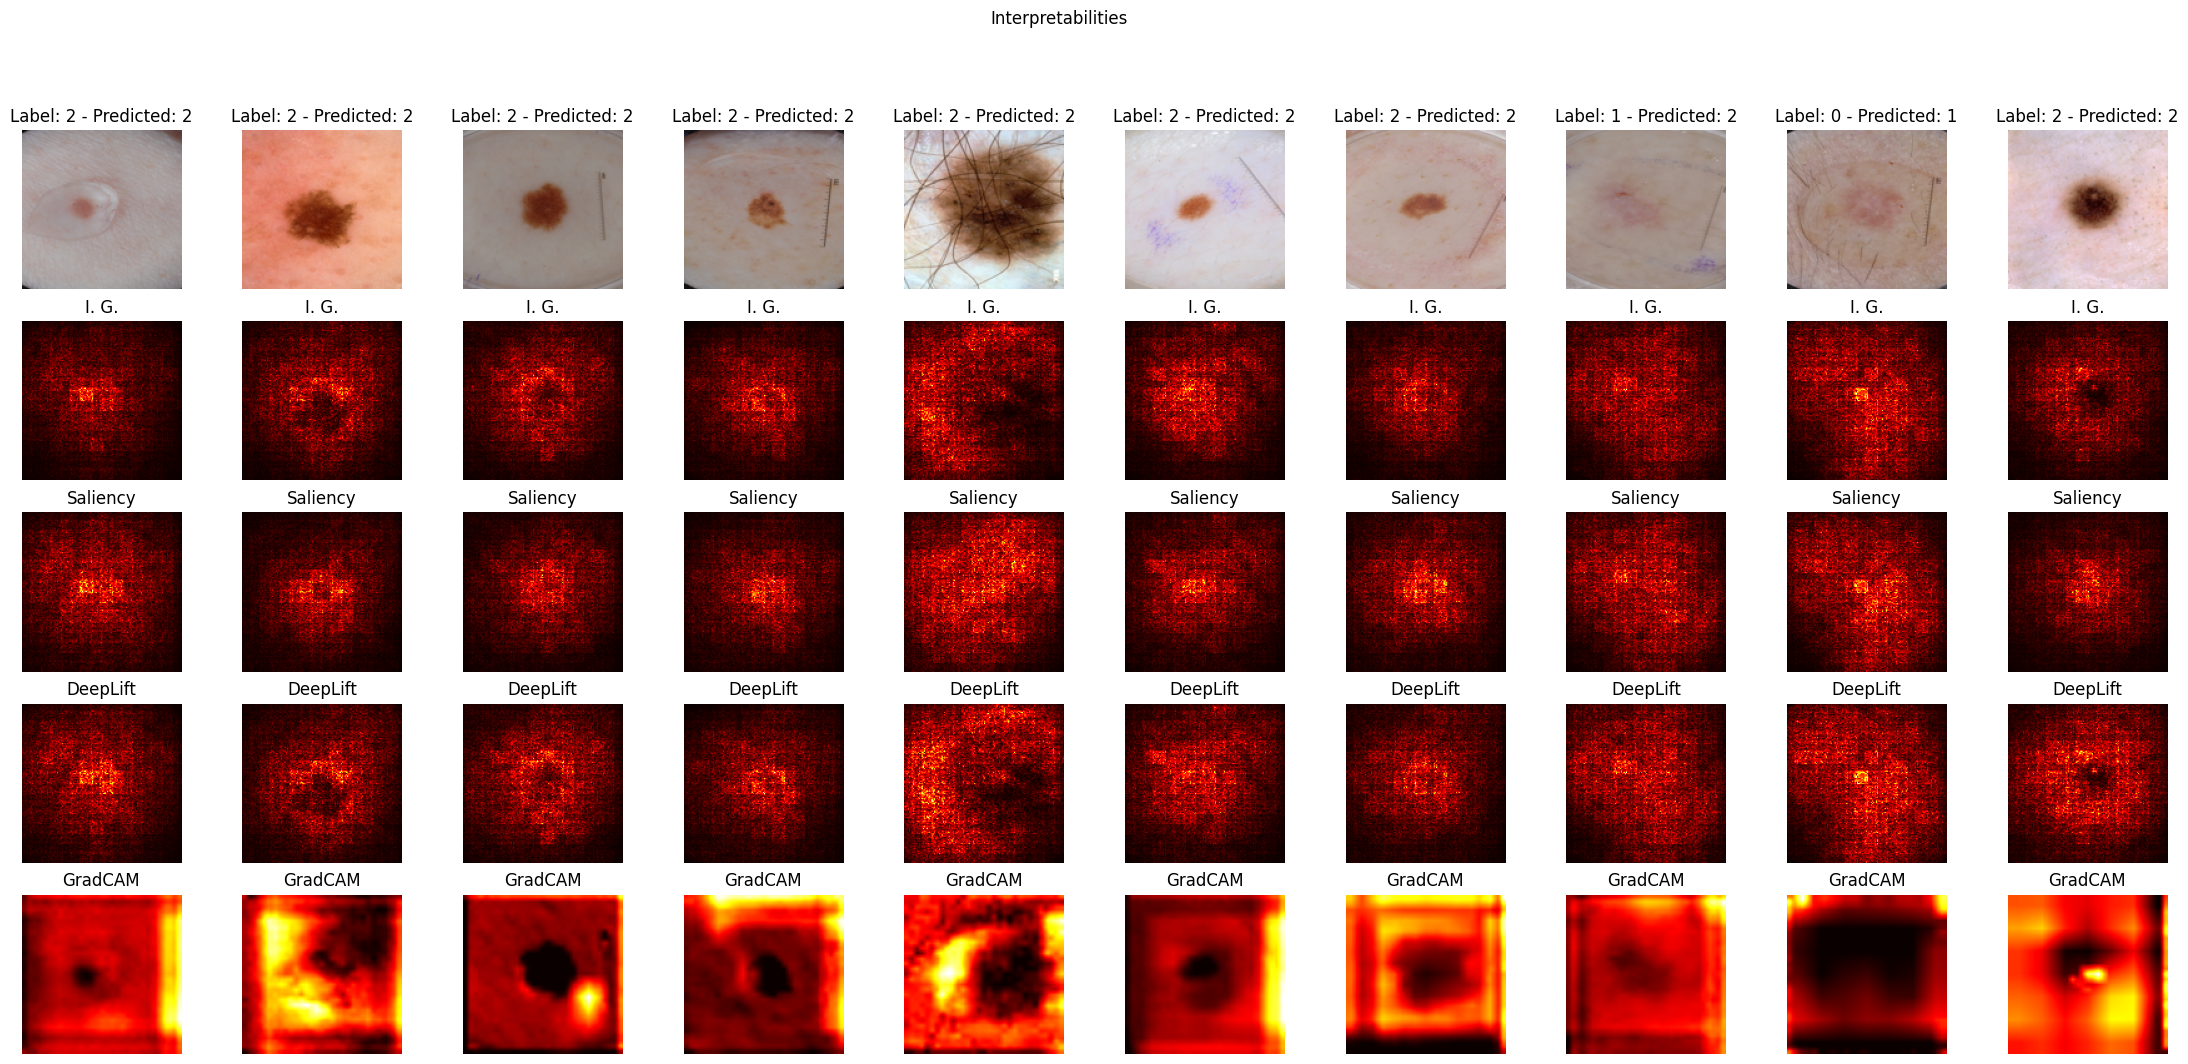

In [ ]:
fig, axs = plt.subplots(5, 10, figsize=(28, 12))
i = 0
for images, ground_truth, _ in test_loader:
    target = ground_truth.squeeze().argmax().item()
    axs[0,i].imshow(images[0].squeeze().permute(2, 1, 0))
    axs[0,i].set_title(f"Label: {target} - Predicted: {interpretabilities_dict['label_predicted'][i]}")
    axs[0,i].axis("off")
    axs[1,i].imshow(interpretabilities_dict['ig'][i], cmap="hot")
    axs[1,i].set_title("I. G.")
    axs[1,i].axis("off")
    axs[2,i].imshow(interpretabilities_dict['saliency'][i], cmap="hot")
    axs[2,i].set_title("Saliency")
    axs[2,i].axis("off")
    axs[3,i].imshow(interpretabilities_dict['deep_lift'][i], cmap="hot")
    axs[3,i].set_title("DeepLift")
    axs[3,i].axis("off")
    axs[4,i].imshow(interpretabilities_dict['grad_cam'][i].T, cmap="hot")
    axs[4,i].set_title("GradCAM")
    axs[4,i].axis("off")
    i += 1
    if i == 10:
        break
fig.suptitle("Interpretabilities")
plt.show()

---

In [ ]:
# function to calculate dice score given two numpy masks
def dice_score(mask1, mask2):
    mask1 = np.asarray(mask1).astype(bool)
    mask2 = np.asarray(mask2).astype(bool)
    intersection = np.sum(mask1 & mask2)
    dice = 2 * intersection / (np.sum(mask1) + np.sum(mask2))
    return dice

# function to calculate the IoU score given two numpy masks
def iou_score(mask1, mask2):
    intersection = np.logical_and(mask1, mask2)
    union = np.logical_or(mask1, mask2)
    return intersection.sum() / union.sum()

In [ ]:
sam2_checkpoint = "../../sam2/checkpoints/sam2.1_hiera_tiny.pt"
model_cfg = "configs/sam2.1/sam2.1_hiera_t.yaml"

sam2_model = build_sam2(model_cfg, sam2_checkpoint, device=device)

predictor = SAM2ImagePredictor(sam2_model)

In [ ]:
sam2_segmentations_dict = {}
sam2_segmentations_dict['ig'] = []
sam2_segmentations_dict['saliency'] = []
sam2_segmentations_dict['deep_lift'] = []
sam2_segmentations_dict['grad_cam'] = []
sam2_segmentations_dict['dice_score_ig'] = []
sam2_segmentations_dict['iou_score_ig'] = []
sam2_segmentations_dict['dice_score_saliency'] = []
sam2_segmentations_dict['iou_score_saliency'] = []
sam2_segmentations_dict['dice_score_deep_lift'] = []
sam2_segmentations_dict['iou_score_deep_lift'] = []
sam2_segmentations_dict['dice_score_grad_cam'] = []
sam2_segmentations_dict['iou_score_grad_cam'] = []

In [ ]:
def preprocess_mask_input_SAM(mask):
    mask = np.array(mask)
    mask = mask.astype(np.float32)
    # apply convolutional filter to the mask using cv2
    kernel = np.ones((5,5),np.float32)/25
    mask = cv2.filter2D(mask,-1,kernel)
    ## binarize the mask
    mean_value = np.mean(mask)
    std_value = np.std(mask)
    mask[mask < mean_value + 2*std_value] = 0
    mask[mask > mean_value + 2*std_value ] = 0
    matrix_sam_fixed = np.zeros((1, 256, 256))  # Initialize the new array
    matrix_sam_fixed[0] = cv2.resize(mask, (256, 256), interpolation=cv2.INTER_LINEAR)
    matrix_sam_fixed = 1 - matrix_sam_fixed
    matrix_sam_fixed = np.array(matrix_sam_fixed).astype(np.float32)
    return matrix_sam_fixed

In [ ]:
#for i, item in enumerate(interpretabilities_dict.items()):
#    print(item)
#    if i == 0:
#        break

In [ ]:
i = 0
n_mask_sam = 1
for images, ground_truth, mask_ground_truth in test_loader:
    predictor.set_image(np.array(images[0].permute(1, 2, 0)))
    
    # Integrated Gradients
    attr_ig = interpretabilities_dict['ig'][i]
    matrix_sam_fixed = preprocess_mask_input_SAM(attr_ig)
    masks, scores, _ = predictor.predict(mask_input = matrix_sam_fixed, multimask_output=True)
    sorted_ind = np.argsort(scores)[::-1]
    masks = masks[sorted_ind]
    mask = 1 - masks[n_mask_sam]
    sam2_segmentations_dict['ig'].append(mask)
    # calculate dice and iou scores
    dice = dice_score(np.array(mask_ground_truth), mask)
    iou = iou_score(np.array(mask_ground_truth), mask)
    sam2_segmentations_dict['dice_score_ig'].append(dice)
    sam2_segmentations_dict['iou_score_ig'].append(iou)

    # Saliency
    attr_saliency = interpretabilities_dict['saliency'][i]
    matrix_sam_fixed = 1 - preprocess_mask_input_SAM(attr_saliency)
    masks, scores, _ = predictor.predict(mask_input = matrix_sam_fixed, multimask_output=True)
    sorted_ind = np.argsort(scores)[::-1]
    masks = masks[sorted_ind]
    mask = 1 - masks[n_mask_sam]
    sam2_segmentations_dict['saliency'].append(mask)
    # calculate dice and iou scores
    dice = dice_score(np.array(mask_ground_truth), mask)
    iou = iou_score(np.array(mask_ground_truth), mask)
    sam2_segmentations_dict['dice_score_saliency'].append(dice)
    sam2_segmentations_dict['iou_score_saliency'].append(iou)

    # DeepLift
    attr_deep_lift = interpretabilities_dict['deep_lift'][i]
    matrix_sam_fixed = preprocess_mask_input_SAM(attr_deep_lift)
    masks, scores, _ = predictor.predict(mask_input = matrix_sam_fixed, multimask_output=True)
    sorted_ind = np.argsort(scores)[::-1]
    masks = masks[sorted_ind]
    mask = 1 - masks[n_mask_sam]
    sam2_segmentations_dict['deep_lift'].append(mask)
    # calculate dice and iou scores
    dice = dice_score(np.array(mask_ground_truth), mask)
    iou = iou_score(np.array(mask_ground_truth), mask)
    sam2_segmentations_dict['dice_score_deep_lift'].append(dice)
    sam2_segmentations_dict['iou_score_deep_lift'].append(iou)

    # Grad Cam
    attr_grad_cam = interpretabilities_dict['grad_cam'][i]
    matrix_sam_fixed = preprocess_mask_input_SAM(attr_grad_cam)
    masks, scores, _ = predictor.predict(mask_input = matrix_sam_fixed, multimask_output=True)
    sorted_ind = np.argsort(scores)[::-1]
    masks = masks[sorted_ind]
    mask = 1 - masks[n_mask_sam]
    sam2_segmentations_dict['grad_cam'].append(mask)
    # calculate dice and iou scores
    dice = dice_score(np.array(mask_ground_truth), mask)
    iou = iou_score(np.array(mask_ground_truth), mask)
    sam2_segmentations_dict['dice_score_grad_cam'].append(dice)
    sam2_segmentations_dict['iou_score_grad_cam'].append(iou)

    i += 1

In [ ]:
df_results = pd.DataFrame(sam2_segmentations_dict, index=test_ids)
df_results = df_results[df_results.columns[4:]]
df_results['label_ground_truth'] = interpretabilities_dict['label_ground_truth']
df_results["label_predicted"] = interpretabilities_dict['label_predicted']
df_results

,dice_score_ig,iou_score_ig,dice_score_saliency,iou_score_saliency,dice_score_deep_lift,iou_score_deep_lift,dice_score_grad_cam,iou_score_grad_cam,label_ground_truth,label_predicted
ISIC_0016028,0.039722,0.020264,0.039722,0.020264,0.039722,0.020264,0.039722,0.020264,2,2
ISIC_0014944,0.932924,0.874281,0.220967,0.124207,0.932924,0.874281,0.932924,0.874281,2,2
ISIC_0015990,0.428744,0.272867,0.468472,0.305885,0.428744,0.272867,0.428744,0.272867,2,2
ISIC_0016057,0.085189,0.044489,0.085224,0.044509,0.085189,0.044489,0.085189,0.044489,2,2
ISIC_0015089,0.722935,0.566091,0.513075,0.345058,0.722935,0.566091,0.722935,0.566091,2,2
...,...,...,...,...,...,...,...,...,...,...
ISIC_0015215,0.304460,0.179565,0.304460,0.179565,0.304460,0.179565,0.304460,0.179565,2,2
ISIC_0015142,0.680387,0.515595,0.681017,0.516320,0.680387,0.515595,0.680387,0.515595,0,2
ISIC_0016015,0.130534,0.069824,0.130541,0.069828,0.130534,0.069824,0.130534,0.069824,2,2
ISIC_0012722,0.025621,0.012977,0.025597,0.012965,0.025621,0.012977,0.025621,0.012977,2,2


In [ ]:
df_results.describe()

,dice_score_ig,iou_score_ig,dice_score_saliency,iou_score_saliency,dice_score_deep_lift,iou_score_deep_lift,dice_score_grad_cam,iou_score_grad_cam,label_ground_truth,label_predicted
count,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000
mean,0.370333,0.267402,0.355469,0.256662,0.370333,0.267402,0.370333,0.267402,1.460000,1.546667
std,0.274049,0.242885,0.277170,0.244317,0.274049,0.242885,0.274049,0.242885,0.799666,0.727120
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.116567,0.061891,0.098033,0.051543,0.116567,0.061891,0.116567,0.061891,1.000000,1.000000
50%,0.320424,0.190777,0.291466,0.170594,0.320424,0.190777,0.320424,0.190777,2.000000,2.000000
75%,0.578561,0.407025,0.573645,0.402176,0.578561,0.407025,0.578561,0.407025,2.000000,2.000000
max,0.993967,0.988006,0.994279,0.988623,0.993967,0.988006,0.993967,0.988006,2.000000,2.000000


In [ ]:
df_results[df_results['label_ground_truth'] == df_results['label_predicted']].describe()

,dice_score_ig,iou_score_ig,dice_score_saliency,iou_score_saliency,dice_score_deep_lift,iou_score_deep_lift,dice_score_grad_cam,iou_score_grad_cam,label_ground_truth,label_predicted
count,403.000000,403.000000,403.000000,403.000000,403.000000,403.000000,403.000000,403.000000,403.000000,403.000000
mean,0.358027,0.258383,0.343151,0.248013,0.358027,0.258383,0.358027,0.258383,1.714640,1.714640
std,0.275420,0.244736,0.279867,0.246264,0.275420,0.244736,0.275420,0.244736,0.611221,0.611221
min,0.000000,0.000000,0.006533,0.003277,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.105706,0.055802,0.089493,0.046843,0.105706,0.055802,0.105706,0.055802,2.000000,2.000000
50%,0.291466,0.170594,0.266229,0.153555,0.291466,0.170594,0.291466,0.170594,2.000000,2.000000
75%,0.559409,0.388325,0.544889,0.374486,0.559409,0.388325,0.559409,0.388325,2.000000,2.000000
max,0.993967,0.988006,0.994279,0.988623,0.993967,0.988006,0.993967,0.988006,2.000000,2.000000


In [ ]:
df_results.to_csv('df_results_skincancer_new_interpretability.csv')

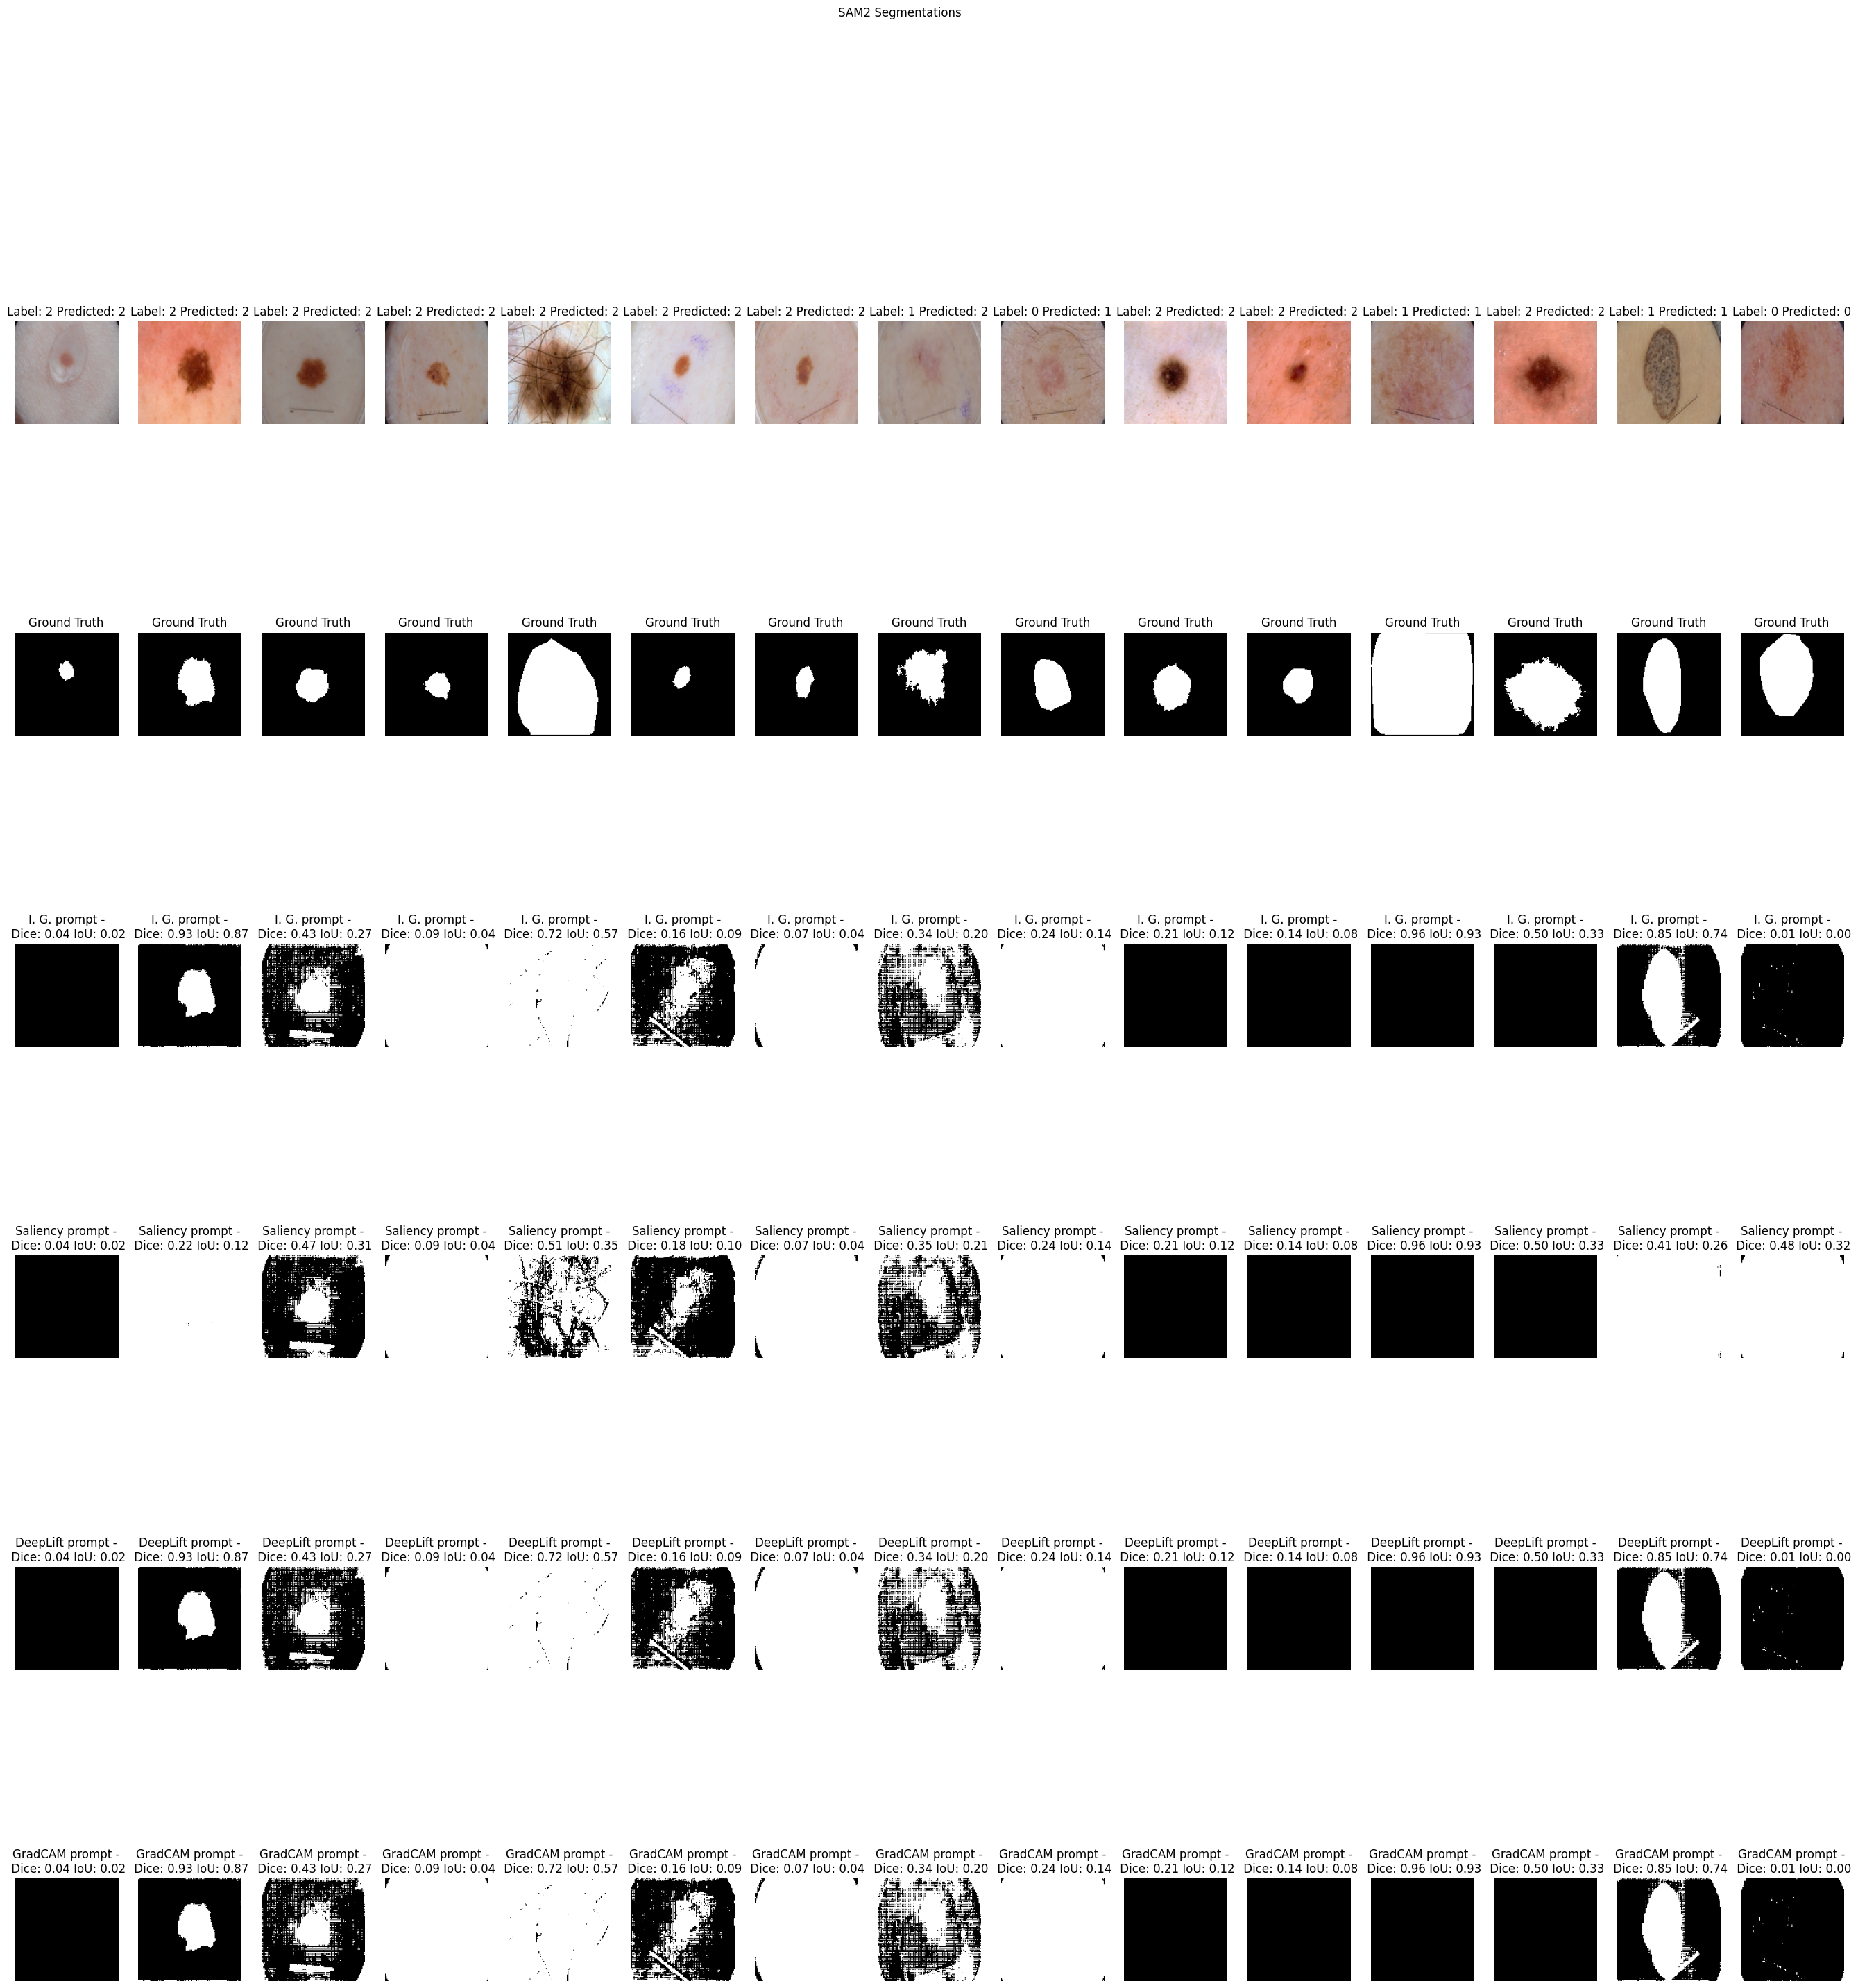

In [ ]:
fig, axs = plt.subplots(6, 15, figsize=(34, 34))
offset = 0
i = 0 + offset
for images, ground_truth, mask_ground_truth in test_loader:
    axs[0,i-offset].imshow(np.array(images[0].permute(1, 2, 0)))
    axs[0,i-offset].set_title(f"Label: {ground_truth.squeeze().argmax().item()} Predicted: {interpretabilities_dict['label_predicted'][i]}")
    axs[0,i-offset].axis("off")
    # show the ground truth mask
    axs[1,i-offset].imshow(np.array(mask_ground_truth.squeeze()), cmap="gray")
    axs[1,i-offset].set_title("Ground Truth")
    axs[1,i-offset].axis("off")
    axs[1+1,i-offset].imshow(sam2_segmentations_dict['ig'][i].squeeze(), cmap="gray")
    axs[1+1,i-offset].set_title("I. G. prompt -\n Dice: {:.2f} IoU: {:.2f}".format(sam2_segmentations_dict['dice_score_ig'][i], sam2_segmentations_dict['iou_score_ig'][i]))
    axs[1+1,i-offset].axis("off")
    axs[2+1,i-offset].imshow(sam2_segmentations_dict['saliency'][i].squeeze(), cmap="gray")
    axs[2+1,i-offset].set_title("Saliency prompt -\n Dice: {:.2f} IoU: {:.2f}".format(sam2_segmentations_dict['dice_score_saliency'][i], sam2_segmentations_dict['iou_score_saliency'][i]))
    axs[2+1,i-offset].axis("off")
    axs[3+1,i-offset].imshow(sam2_segmentations_dict['deep_lift'][i].squeeze(), cmap="gray")
    axs[3+1,i-offset].set_title("DeepLift prompt -\n Dice: {:.2f} IoU: {:.2f}".format(sam2_segmentations_dict['dice_score_deep_lift'][i], sam2_segmentations_dict['iou_score_deep_lift'][i]))
    axs[3+1,i-offset].axis("off")
    axs[4+1,i-offset].imshow(sam2_segmentations_dict['grad_cam'][i].squeeze(), cmap="gray")
    axs[4+1,i-offset].set_title("GradCAM prompt -\n Dice: {:.2f} IoU: {:.2f}".format(sam2_segmentations_dict['dice_score_grad_cam'][i], sam2_segmentations_dict['iou_score_grad_cam'][i]))
    axs[4+1,i-offset].axis("off")
    i = i + 1
    if i == 15 + offset:
        break
fig.suptitle("SAM2 Segmentations")
plt.show()